In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
plt.rcParams.update(plt.rcParamsDefault)

import cvxpy as cp
""" plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    }) """

' plt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "sans-serif",\n    "font.sans-serif": ["Helvetica Neue"],\n    "font.size": 28,\n    }) '

In [2]:
# Load data
prices = pd.read_csv("portfolio_data.csv")
returns = (np.array(prices.iloc[1:,:]) - np.array(prices.iloc[:-1,:])) / prices.iloc[:-1,:]
R = returns.iloc[:2000,:].to_numpy()
R_test = returns.iloc[2000:2500,:].to_numpy()
#returns.to_csv("portfolio_returns.csv")

## Cumulative portfolio value over time

In [3]:
# Cumulative portfolo value over time
def portfolio_V(V_0, r):
    return V_0 * np.cumprod(1 + r)

# Check exact value vs approximation
T = 250
mu, sigma = .10/T, .05/np.sqrt(T)
r = mu + sigma * np.random.randn(T)
V0 = 10000
V = portfolio_V(V0, r)

print("V_T original = ", V[T-1])
print("V_T approx = ", (V0*(1 + np.sum(r))))

V_T original =  10383.78646044332
V_T approx =  10389.065946114864


## Portfolio return, risk and leverage

In [4]:
T, n = R.shape
T_test = R_test.shape[0]
w = np.ones(n)/n  # equal portfolio
r = R @ w # portfolio return time series

def annualize_return(r):
     return 250 * np.sum(r) / len(r)
    
def annualize_risk(r):
    return 250 * np.linalg.norm(r - np.mean(r) * np.ones(len(r)), 1) / len(r)
    # return np.sqrt(250) * np.std(r)

def leverage(w):
    return np.linalg.norm(w, 1)
    

pf_return = annualize_return(r)
pf_risk = annualize_risk(r)
pf_leverage = leverage(w)
print("Portfolio return = %.2f%%" % (pf_return * 100))
print("Portfolio risk = %.2f%%" % (pf_risk * 100))
print("Leverage = %.2f" % (pf_leverage))

Portfolio return = 9.66%
Portfolio risk = 232.69%
Leverage = 1.00


## Optimize for different trade-off parameters $\lambda$

[0.01       0.00464159 0.00215443 0.001     ]
w:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


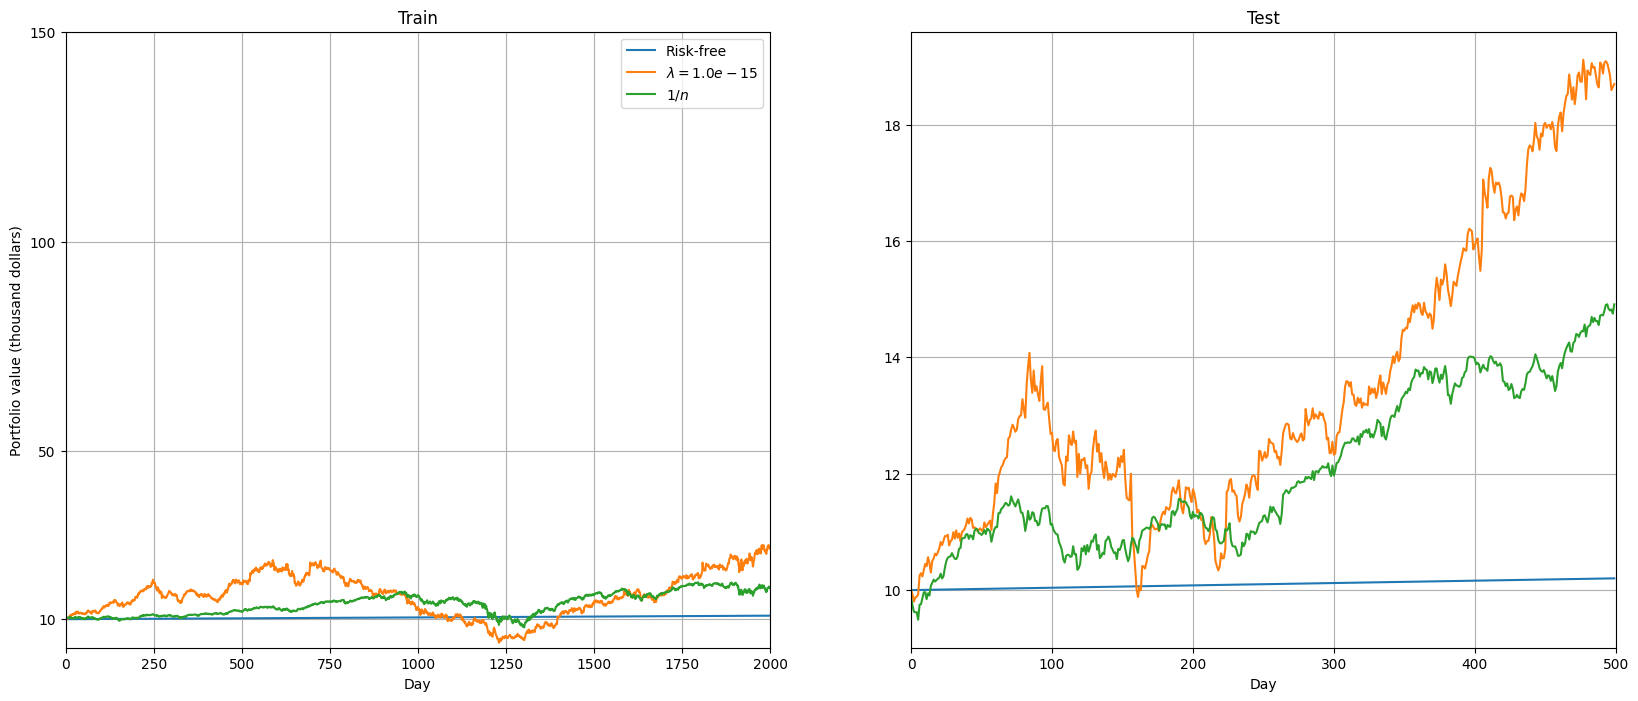

In [7]:
V0 = 10000
n_lam = 4
lam_vec = np.logspace(-3, -2, n_lam)[::-1]
print(lam_vec)
n_assets = R.shape[1]
w_data = {}
results = []

def compute_results(w, r_train, r_test):
    return {'Train return': annualize_return(r_train), 
            'Test return': annualize_return(r_test),
            'Train risk': annualize_risk(r_train),
            'Test risk': annualize_risk(r_test),
            # 'Leverage': leverage(w)
           }

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Risk free
w = np.zeros(n_assets); w[-1] = 1
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series

w_data.update({r"$\rm \mbox{Risk-free}$": w})  # append data
results.append(compute_results(w, r_train, r_test)) # append results
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"Risk-free")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)
# Different lambdas

# Define optimization problem
w_var = cp.Variable(n_assets)
lam = cp.Parameter(nonneg=True)
# mu is c
mu = np.mean(R, axis=0)  # Average returns across time
# ret is c'*x
ret = - mu @ w_var 
# risk is the norm of the average return, we want the variance
risk = cp.norm(R @ w_var - ret * np.ones(T), 1)/T
objective = ret + lam * risk
constraints = [cp.sum(w_var) == 1, w_var >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)


for k in range(1):
    lam.value = lam_vec[k]
    lam.value = 1e-15
    lam_string = r"$\lambda = {l:.1e}$".format(l=1e-15)#lam_vec[k])
    problem.solve()
    w = w_var.value
    r_train = R @ w  # Return time series
    #print("r_train: ",r_train)
    r_test = R_test @ w  # Test return time series
    w_data.update({lam_string: w})
    print("w: ", [ round(elem, 2) for elem in w])
    results.append(compute_results(w, r_train, r_test))
    ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=lam_string)
    ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)
    
# Equal invesetment
w = np.ones(n_assets)/n_assets
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series
w_data.update({r"$1/n$": w})
results.append(compute_results(w, r_train, r_test))
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"$1/n$")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)


# Create dataframe from results (round to 2 decimals)
df_results = pd.DataFrame(results).round(2)

# Complete plot
ax[0].set_ylabel("Portfolio value (thousand dollars)")
ax[0].set_title("Train")
ax[0].set_xlabel("Day")
ax[0].set_yticks([10, 50, 100, 150])
ax[0].set_xlim([0, T])
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("Day")
ax[1].set_title("Test")
ax[1].set_yticks([10, 12, 14, 16, 18])
ax[1].set_xlim([0, T_test])
ax[1].grid()
plt.savefig("total_portfolio.pdf")

In [ ]:
w_df = pd.DataFrame(w_data).T.round(2)
w_df.columns = prices.columns
w_df

In [ ]:
df_results.index = w_df.index  # Use same index to list allocations
df_results

In [ ]:
# print(df_results.to_latex(index=True, escape=False, float_format=r"$%.2f$"))

## Return vs risk pareto frontier (training data)

In [ ]:
# Compute returns for individual investments
individual_data =[]

for k in range(n_assets):
    # w = e_k -> r = Rw = kth column of R
    r = R[:, k]
    individual_data.append({'risk': annualize_risk(r),
                            'return': annualize_return(r)})

df_individual = pd.DataFrame(individual_data)
df_individual.index = w_df.columns
df_individual

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
# ax.plot(x_pareto, y_pareto)
ax.scatter(df_individual['risk'], df_individual['return'],  marker='o', s=70, color='k', facecolors='none') 
ax.scatter(df_results['Train risk'], df_results['Train return'],  marker='o', s=70, color='k', facecolors='k', clip_on=False) 
ax.plot(df_results['Train risk'][:-1], df_results['Train return'][:-1], color="k") 

# Annotate risk free and equal investments
ax.annotate(r'Risk-free', 
               (df_results['Train risk'][0], df_results['Train return'][0]),
               textcoords="offset points", # how to position the text
               xytext=(10,-60), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )
ax.annotate(r'$1/n$', 
               (df_results['Train risk'][-1], df_results['Train return'][-1]),
               textcoords="offset points", # how to position the text
               xytext=(-40,40), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )
    
# ax.set_xlim((0, 0.7))
# ax.set_ylim((-0.1, 0.5))
ax.grid()
ax.set_xlabel("Annualized risk")
ax.set_ylabel("Annualized return")
plt.savefig("pareto_portfolio.pdf")